# Study of Pupil magnification

## Survey of pupil magnification in lens designs that form *real* images

In [1]:
from __future__ import print_function, division
import os
import numpy as np
import matplotlib.pyplot as plt
import pyzdde.zdde as pyz

In [2]:
%matplotlib inline

In [3]:
def get_pupilMagnification_data(ln):
    """return pupil magnification and other relevant data
    
    Parameters
    ----------
    None
    
    Returns
    -------
    zFileName : string
        zmx file name (without extension and path)
    zTitle : string
        zmx lens title
    fl : real
        focal length (mm)
    imgFNum : real
        the image space F/# is the infinite conjugate paraxial F/# 
        i.e. eff. focal length / paraxial entrance pupil diameter
    mp : real
        pupil magnification 
    """
    LENS_TITLE = 16
    zfileName = os.path.split(ln.zGetFile())[1].split('.')[0]
    zTitle = ln.zGetSystemProperty(code=LENS_TITLE)
    mp = ln.zGetPupilMagnification()
    imgFNum = pyz.numAper2fnum(ln.zGetImageSpaceNA())
    fl = ln.zGetFirst().EFL
    return zfileName, zTitle, fl, imgFNum, mp

# Notes:
# Irrespective of the Lens Unit set in the lens file, Zemax always returns the
# focal length in mm, so there is no need to check and/or change the lens unit
# before getting the focal length.

##### Generation of new pupil magnification data

In [4]:
parentDir = os.path.join(os.getcwd(), 'zmxfiles')
zmxLensDirList = ['doublegauss', 'doubleMeniscus', 
                 'inversetele_retrofocus_wideangle',
                 'microscopeObjectives', 'telephoto', 'triplets']
fext = ".zmx"


def retrieve_pupil_mag_data():
    """creates text files in the current directory with names
    "pupil_mag_data_xxx.txt". Each file contains data (as shown below)
    produced from the zmx files present in the directory named xxx.
    
    assumption: 'xxx' are directory names under the directory 'zmxfiles',
    such as 'doublegauss', 'doubleMeniscus', etc.
    
    Format of pupil magnification data:
    
    FILENAME, LENS TITLE, FOCAL LENGTH (mm), F-NUMBER, PUPIL MAG
    
    E.g. E_001, COOKE TRIPLET ANASTIGMAT, 127.04, 3.50, 1.0197
    
    Note
    ----
    Call this function to generate new data. Data files
    shall be overwritten.
    """
    ln = pyz.createLink()
    for eachDir in zmxLensDirList:
        eachDirPath = os.path.join(parentDir, eachDir)
        fnames = [os.path.join(eachDirPath, zfile)
                  for zfile in os.listdir(eachDirPath) if zfile.lower().endswith(fext)]
        txtFileName = 'pupil_mag_data_{}.txt'.format(eachDir)
        with open(txtFileName, 'w') as dfile:
            for eachFile in fnames:
                ln.zLoadFile(eachFile)
                data = get_pupilMagnification_data(ln)
                dfile.write('{}, {}, {:0.2f}, {:0.2f}, {:0.4f}\n'
                            .format(data[0], data[1].replace(',','-'),
                                    data[2], data[3], data[4]))
    ln.close()
    print('Generated data!')

In [47]:
# Call this function if new data has to be generated.

retrieve_pupil_mag_data()

Generated data!


##### Plot and analysis of pupil magnification data

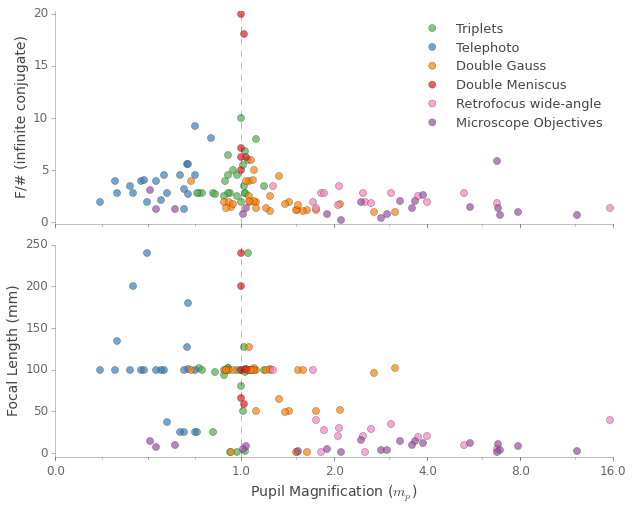

In [11]:
bSAVE_FIG = False  # Toggle flag to choose

curDir = os.getcwd()

zmxLensDirList = ['triplets', 'telephoto','doublegauss', 'doubleMeniscus',
                  'inversetele_retrofocus_wideangle', 'microscopeObjectives']

legtxt = ['Triplets', 'Telephoto', 'Double Gauss', 'Double Meniscus',
          'Retrofocus wide-angle', 'Microscope Objectives']

#cols = ['#4daf4a', '#377eb8', '#ff7f00', '#e41a1c',  '#984ea3', '#f781bf', ] 
#cols = ['#4daf4a', '#377eb8', '#ffe600', '#e41a1c',  '#ff7f00', '#f781bf', ] 
cols = ['#4daf4a', '#377eb8', '#ff7f00', '#e41a1c',  '#f781bf', '#984ea3',  ] 

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

ax0, ax1 = axes.flatten()

# figure decorations
#ax0.set_xlabel('Pupil Magnification', fontsize=14)
ax1.set_xlabel('Pupil Magnification ($m_p$)', fontsize=14)
ax0.set_ylabel('F/# (infinite conjugate)', fontsize=14)
ax1.set_ylabel('Focal Length (mm)', fontsize=14)
#ax0.set_title('Focal length vs Pupil Magnification', y=1.01, fontsize=14)
#ax1.set_title('F-number vs Pupil Magnification', y=1.01, fontsize=14)

ax0.set_xlim(0, 16)
ax1.set_xlim(0, 16)
ax0.set_ylim(-0.1, 20.25)
ax1.set_ylim(-5, 250)

ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax0.xaxis.set_ticks_position('bottom')
ax0.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')

ax0.set_xscale(value='symlog', basex=2, linthreshx=1.0, subsx=[0.25, 0.5, 0.75, 4, 8])
ax1.set_xscale(value='symlog', basex=2, linthreshx=1.0, subsx=[0.25, 0.5, 0.75, 4, 8])

ticloc = ax0.xaxis.get_ticklocs()
ax0.xaxis.set_ticklabels(ticloc)
ax1.xaxis.set_ticklabels(ticloc)


fig.subplots_adjust(hspace=0.1)

ax0.axvline(x=1.0, color='k', linestyle='dashed', linewidth=0.7, alpha=0.4)
ax1.axvline(x=1.0, color='k', linestyle='dashed', linewidth=0.7, alpha=0.4)

# actual plot of the data 
for i, each in enumerate(zmxLensDirList):
    txtFileName = os.path.join(curDir, 'pupil_mag_data_{}.txt'.format(each))
    focalLength = []
    fnumber = []
    pupilmag = []
    with open(txtFileName, 'r') as dfile:
        for line in dfile:
            data = line.rstrip().split(',')
            focalLength.append(float(data[2]))
            fnumber.append(float(data[3]))
            pupilmag.append(float(data[4]))
    ax0.scatter(pupilmag, fnumber, c=cols[i], s=50, alpha=0.7, 
                lw=0.4, label=legtxt[i])
    ax1.scatter(pupilmag, focalLength, c=cols[i], s=50, alpha=0.7, 
                lw=0.4, label=legtxt[i])
    
ax0.legend(fontsize=13, scatterpoints=1, markerscale=1.0, scatteryoffsets=[0.5])
#ax1.legend(fontsize=12, scatterpoints=1, markerscale=1.0, scatteryoffsets=[0.5])

if bSAVE_FIG:
    fig.savefig("pupil_mag_vs_fnum_focal.png", dpi=400, bbox_inches='tight', pad_inches=0.04)

plt.show()

We can infer the following by observing the plots:

1. There is no correlation between pupil magnification and focal length or F-number.
2. Pupil magnification of telephoto lenses tend to be less than 1.0.
3. Pupil magnification of retro-focus wide-angle lenses (also called inverse telephoto lens) tend to be greater than 1.0
4. The double meniscus lenses tend to have pupil magnification approximately equal to 1.0. This is due to their symmetric lens design. 

The (effective) focal length of a normal lens is the distance from the rear principal plane to the plane at which an object at infinity is brought to focus. The distance required to focus an object at finite distance from the lens is greater than the focal length as predicted by the Guassian lens equation. The rear principal plane is located within the physical extents in a normal lenses. Therefore, normal (or "true") long focal length lenses are at least as long as the focal length of the lens. 

To make long focal length lenses within a compact body, lens designers employ a negative focal length lens (or a group of elements with net negative focal length) behind a positive focal length lens (or a group of elements). This combination of lenses system attains a positive long focal length within a short body (see [ref]) and behaves identical to an equivalent true long focal length in terms the geometric characteristics of the image. For example, the length of a 200 mm normal lens would be at least 200 mm (at infinite conjugate). However, combining a 75 mm and -25 mm with a 60 mm separation produces a two-lens system with effective focal length of 200 mm and back focal length (bfl) of 40 mm. Therefore, the the body of this combined lens system is only 100 mm (separation distance plus the bfl) at infinite conjugate.

While the negative focal length lens (or group) compacts the lens, being a diverging lens, it also produces a dimunitive image of the stop viewed from the image side compared to the image of the stop formed by the positive focal length elements viewed from the object side. In other words, a consequence of the telephoto design is that the exit pupil becomes smaller compared to the entrace pupil. Therefore, the pupil magnification for telephoto lenses is less than one.



In [37]:
# Other statistics
curDir = os.getcwd()

zmxLensDirList = ['triplets', 'telephoto','doublegauss',  
                  'doubleMeniscus', 'microscopeObjectives',
                  'inversetele_retrofocus_wideangle']

pupilmag = []

for i, each in enumerate(zmxLensDirList):
    txtFileName = os.path.join(curDir, 'pupil_mag_data_{}.txt'.format(each))
    with open(txtFileName, 'r') as dfile:
        for line in dfile:
            data = line.rstrip().split(',')
            pupilmag.append(float(data[4]))
            
pupilmag = np.array(pupilmag)

In [38]:
len(pupilmag)

120

In [43]:
# mean and median
print('mean m_p = {:0.4f}, median m_p = {:0.4f}'.format(np.mean(pupilmag), np.median(pupilmag)))

mean m_p = 1.8309, median m_p = 1.0449


In [71]:
# percentage of pupil magnification near 1.0
pupilmagNearOne = np.sum(np.logical_and(0.95 < pupilmag, pupilmag < 1.05)) # within 5% of 1.0
percentagePupilmagNearOne = np.round((100*pupilmagNearOne)/len(pupilmag))
print('Number of lenses = {}\n % of lenses = {:0.0f}'.format(pupilmagNearOne, percentagePupilmagNearOne))

Number of lenses = 20
 % of lenses = 17


In [73]:
1/6 # one is six lens

0.16666666666666666